## Feature Engineering

In [2]:
! pip install medpy

     |████████████████████████████████| 151 kB 1.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 45.5 MB 1.9 MB/s             
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214957 sha256=34dc7f2db34e6dd61a52afec2319d308b8b929af2f53379633f07c4fcec36d59
  Stored in directory: /Users/kuladeep/Library/Caches/pip/wheels/fc/38/7d/e0b8bcb2770f779a93cab5ab7fa6dd344011e1278cb90cab86
Successfully built medpy
You should consider upgrading via the '/Users/kuladeep/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import IPython
from PIL import Image
import pywt
import skimage.measure 
from scipy.optimize import differential_evolution
from skimage.filters import unsharp_mask
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.metrics import peak_signal_noise_ratio
import medpy
from medpy.filter import *

## Histogram equalization

In [5]:
# read a image using imread
img = cv.imread('10004.jpg')
equ=np.zeros([img.shape[0],img.shape[1],3])
# creating a Histograms Equalization
for i in range(3):
    equ[:,:,i] = cv.equalizeHist(img[:,:,i])

# stacking images side-by-side
res = np.hstack((img, equ))
  
# # show image input vs output
cv.imwrite('res.jpg',res)
cv.imwrite('he.jpg',equ)


True

## Histogram equalization on HSV colourspace

In [6]:
image = cv.imread("10004.jpg")

# convert image from RGB to HSV
img_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

# Histogram equalisation on the V-channel
img_hsv[:, :, 2] = cv.equalizeHist(img_hsv[:, :, 2])

# convert image back from HSV to RGB
image_new = cv.cvtColor(img_hsv, cv.COLOR_HSV2RGB)
# stacking images side-by-side
res = np.hstack((image,image_new  ))
cv.imwrite('res2.jpg',res)
cv.imwrite('he_hsv.jpg',image_new)

True

## Histogram equalization on HSV colourspace+HE on RGB space+Gaussian filter

In [7]:
image = cv.imread("10004.jpg")

# convert image from RGB to HSV
img_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

# Histogram equalisation on the V-channel
img_hsv[:, :, 2] = cv.equalizeHist(img_hsv[:, :, 2])

# convert image back from HSV to RGB
image_new = cv.cvtColor(img_hsv, cv.COLOR_HSV2RGB)

equ=np.zeros([img.shape[0],img.shape[1],3])
# creating a Histograms Equalization
for i in range(3):
    equ[:,:,i] = cv.equalizeHist(image_new[:,:,i])

blur = cv.GaussianBlur(equ,(3,3),0.5)
# stacking images side-by-side
res = np.hstack((image, blur))

# # show image input vs output
cv.imwrite('res3.jpg',res)
cv.imwrite('he_hsv_gf.jpg',blur)

True

## Histogram equalization on YUV colourspace

In [8]:
# load the source image
img = cv.imread('10004.jpg')

# convert it to grayscale
img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)

# apply histogram equalization 
img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
hist_eq = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
res=np.hstack((img, hist_eq))
cv.imwrite('res6.jpg',res)
cv.imwrite('he_yuv.jpg',hist_eq)

True

## Contrast Stretching

In [9]:
a=0
b=255
def contrast_stretching(band):
    # to remove effect of outliers
    c=np.percentile(band,5)
    d=np.percentile(band,95)
    normalized_channel=(band-c)*((b-a)/(d-c))+a
    return normalized_channel

In [10]:
img = cv.imread('10004.jpg')

new_image=np.zeros([img.shape[0],img.shape[1],3])
for i in range(3):
    new_image[:,:,i]=contrast_stretching(img[:,:,i])
res = np.hstack((img, new_image))

# show image input vs output
cv.imwrite('res5.jpg',res)
cv.imwrite('contrast_stretching.jpg',new_image)

True

## Automatic Underwater Image processing

In [24]:
def GaussianLowPass(img, size1,size2, Do) -> list:
    D1 = np.zeros([size1, size2], dtype=np.uint32)
    H1 = np.zeros([size1, size2], dtype=float)
    r1 = img.shape[0] // 2
    c1 = img.shape[1] // 2
    for u in range(0, size1):
        for v in range(0, size2):
            D1[u, v] = np.sqrt((u - r1) ** 2 + (v - c1) ** 2)
    for i in range(size1):
        for j in range(size2):
            H1[i, j] = np.exp(-D1[i, j] ** 2 / (2 * Do) ** 2)
    return [H1, D1]

In [25]:
# Remove moire pattern
Do1 = 200
img1 = cv.imread('10004.jpg')
size1 = img1.shape[0]
size2 = img1.shape[1]
H1, D1 = GaussianLowPass(img1, size1,size2, Do1)
transformed_image=[]
for i in range(3):
    input2 = np.fft.fftshift(np.fft.fft2(img1[:,:,i]))
    out1 = H1 * input2
    out1 = np.abs(np.fft.ifft2(np.fft.ifftshift(out1)))
    out1 = np.uint8(cv.normalize(out1, None, 0, 255, cv.NORM_MINMAX, -1))
    transformed_image.append(out1)
final_image = np.dstack([transformed_image[0].astype(int), 
                             transformed_image[1].astype(int), 
                             transformed_image[2].astype(int)])
# Resize image
resize_image=np.zeros((1280,1280,3))
resize_image[:280,:,]=final_image[:280,:,]
resize_image[280:1000,:,]=final_image[:,:,]
resize_image[1000:,:,]=final_image[440:,:,]
# Converting color space from RGB to YCbCr 
cv.imwrite('resize.jpg',resize_image)
resize_image=cv.imread('resize.jpg')
YCrCb = cv.cvtColor(resize_image, cv.COLOR_BGR2YCR_CB) 

In [26]:
# Homomorphic filtering
img = YCrCb[:,:,0]

hh, ww = img.shape[:2]

# take ln of image
img_log = np.log(np.float64(img), dtype=np.float64)

# do dft saving as complex output
dft = np.fft.fft2(img_log, axes=(0,1))

# apply shift of origin to center of image
dft_shift = np.fft.fftshift(dft)

# create black circle on white background for high pass filter

radius = 50
mask = np.zeros_like(img, dtype=np.float64)
cy = mask.shape[0] // 2
cx = mask.shape[1] // 2
cv.circle(mask, (cx,cy), radius, 1, -1)
mask = 1 - mask

# antialias mask via blurring

mask = cv.GaussianBlur(mask, (201,201), 0)

# apply mask to dft_shift
dft_shift_filtered = np.multiply(dft_shift,mask)

# shift origin from center to upper left corner
back_ishift = np.fft.ifftshift(dft_shift_filtered)

# do idft saving as complex
img_back = np.fft.ifft2(back_ishift, axes=(0,1))

# combine complex real and imaginary components to form (the magnitude for) the original image again
img_back = np.abs(img_back)

# apply exp to reverse the earlier log
img_homomorphic = np.exp(img_back, dtype=np.float64)


In [27]:
img_float=img_as_float(img_homomorphic)
# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(img_float,average_sigmas=True)

im_bayes = denoise_wavelet(img_float, method='BayesShrink', mode='soft', wavelet_levels=3, rescale_sigma=True)
im_visushrink = denoise_wavelet(img_float,method='VisuShrink', mode='soft', sigma=sigma_est/3, wavelet_levels=5,rescale_sigma=True)

In [28]:
im_diffusion=medpy.filter.smoothing.anisotropic_diffusion(im_bayes, niter=1, kappa=10, gamma=0.1, voxelspacing=None, option=1)

In [29]:
a=0
b=1
def contrast_stretching2(band):
    # to remove effect of outliers
    c=np.percentile(band,5)
    d=np.percentile(band,95)
    normalized_channel=(band-c)*((b-a)/(d-c))+a
    return normalized_channel

In [30]:
im_cstretched=contrast_stretching2(im_diffusion)
im_ycrcb=np.dstack([np.uint8(im_cstretched*255),YCrCb[:,:,1],YCrCb[:,:,2]])
backto_originalshape=np.zeros((720,1280,3))
backto_originalshape[:,:,]=im_ycrcb[280:1000,:,]

In [31]:
cv.imwrite('b.jpg',backto_originalshape)

True

In [32]:
backto_originalshape=cv.imread('b.jpg')
img_bgr = cv.cvtColor(backto_originalshape, cv.COLOR_YCrCb2BGR)
for i in range(3):
  img_bgr[:,:,i]= cv.equalizeHist(img_bgr[:,:,i])

In [33]:
cv.imwrite('b2.jpg',img_bgr)

True

In [46]:
peak_signal_noise_ratio(img_float, im_visushrink)

ValueError: im_true has intensity values outside the range expected for its data type.  Please manually specify the data_range

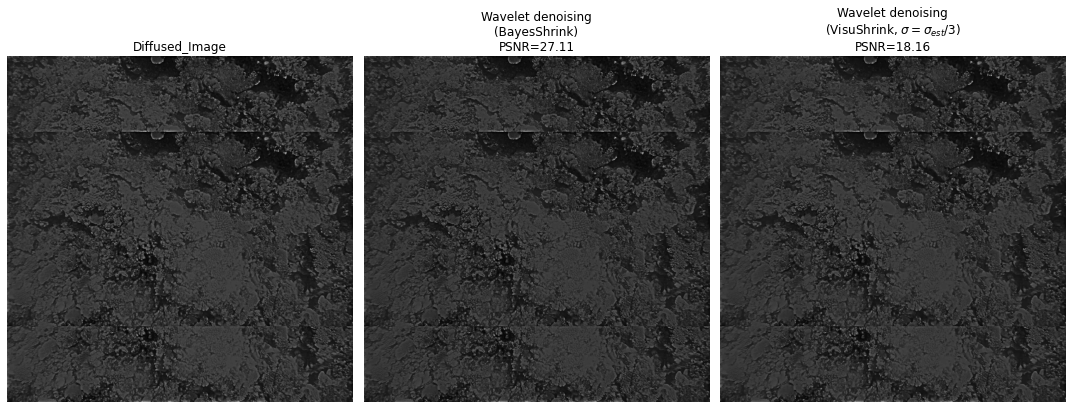

In [52]:
# Compute PSNR as an indication of image quality
psnr_visushrink = peak_signal_noise_ratio(img_float, im_visushrink,data_range=1.0)
psnr_bayes = peak_signal_noise_ratio(img_float, im_bayes,data_range=1.0)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10),sharex=True, sharey=True)
plt.gray()
ax[0].imshow(im_cstretched)
ax[0].axis('off')
ax[0].set_title('Diffused_Image')
ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[2].imshow(im_visushrink)
ax[2].axis('off')
ax[2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/3$)\n'
     'PSNR=%0.4g' % psnr_visushrink)
fig.tight_layout()

plt.show()

## Contrast Adjustment via Differential Evolution Algorithm 

In [42]:
def contrast_stretching(a,b,band):
    # to remove effect of outliers
    c=np.percentile(band,5)
    d=np.percentile(band,95)
    normalized_channel=(band-c)*((b-a)/(d-c))+a
    return normalized_channel

In [43]:
def obj_func_1(lowerlimit):
  sum=0
  a=lowerlimit
  b=1-a
  channels=img[:,:,0]
  image=channels/255.0
  row=image.shape[0]
  col=image.shape[1]
  image=contrast_stretching(a,b,image)
  entropy = skimage.measure.shannon_entropy(image)
  for i in range(row-1):
    for j in range(col-1):
      gx=image[i+1][j]-image[i][j]
      gy=image[i][j+1]-image[i][j]
      sum=sum+np.sqrt(gx**2+gy**2)
  return -1*(sum/(row*col)+entropy)
def obj_func_2(lowerlimit):
  sum=0
  a=lowerlimit
  b=1-a
  channels=img[:,:,1]
  image=channels/255.0
  row=image.shape[0]
  col=image.shape[1]
  image=contrast_stretching(a,b,image)
  entropy = skimage.measure.shannon_entropy(image)
  for i in range(row-1):
    for j in range(col-1):
      gx=image[i+1][j]-image[i][j]
      gy=image[i][j+1]-image[i][j]
      sum=sum+np.sqrt(gx**2+gy**2)
  return -1*(sum/(row*col)+entropy)
def obj_func_3(lowerlimit):
  sum=0
  a=lowerlimit
  b=1-a
  channels=img[:,:,2]
  image=channels/255.0
  row=image.shape[0]
  col=image.shape[1]
  image=contrast_stretching(a,b,image)
  entropy = skimage.measure.shannon_entropy(image)
  for i in range(row-1):
    for j in range(col-1):
      gx=image[i+1][j]-image[i][j]
      gy=image[i][j+1]-image[i][j]
      sum=sum+np.sqrt(gx**2+gy**2)
  return -1*(sum/(row*col)+entropy)

In [44]:
img=cv.imread('10004.jpg')
bounds = [(0, 0.5)]
result1= differential_evolution(obj_func_1, bounds,recombination=0.8,popsize=40 ,mutation=0.8,seed=1)
result2= differential_evolution(obj_func_2, bounds,recombination=0.8,popsize=40 ,mutation=0.8,seed=1)
result3= differential_evolution(obj_func_3, bounds,recombination=0.8,popsize=40 ,mutation=0.8,seed=1)

In [53]:
channel1=img[:,:,0]
channel1=contrast_stretching(np.abs(result1.jac[0]),1-np.abs(result1.jac[0]),channel1)
channel2=img[:,:,1]
channel2=contrast_stretching(np.abs(result2.jac[0]),1-np.abs(result2.jac[0]),channel2)
channel3=img[:,:,2]
channel3=contrast_stretching(np.abs(result3.jac[0]),1-np.abs(result3.jac[0]),channel3)
reconstucted_image=np.dstack([channel1,channel2,channel3])
reconstucted_image = unsharp_mask(reconstucted_image, radius=20, amount=1)
cv.imwrite("diff_evolution.jpg", np.uint8(reconstucted_image*255))

True

In [56]:
img=cv.imread('10004.jpg')
entropy_re = skimage.measure.shannon_entropy(reconstucted_image)
print('Reconstructed_image_entropy',round(entropy_re,3))
entropy = skimage.measure.shannon_entropy(img)
print('Original_image_entropy',round(entropy,3))
print('With Differential_evolution the underwater image was enhanced with a ratio of {:.3f} %'.format((entropy_re-entropy)/entropy*100))

Reconstructed_image_entropy 21.138
Original_image_entropy 7.903
With Differential_evolution the underwater image was enhanced with a ratio of 167.459 %


In [58]:
automatic=cv.imread('b2.jpg')
automatic=cv.cvtColor(automatic,cv.COLOR_BGR2RGB)
he_hsv=cv.imread('contrast_stretching.jpg')
he_hsv=cv.cvtColor(he_hsv,cv.COLOR_BGR2RGB)
he_hsv_gf=cv.imread('diff_evolution.jpg')
he_hsv_gf=cv.cvtColor(he_hsv_gf,cv.COLOR_BGR2RGB)
he_yuv=cv.imread('uwcnn10004.jpg')
he_yuv=cv.cvtColor(he_yuv,cv.COLOR_BGR2RGB)

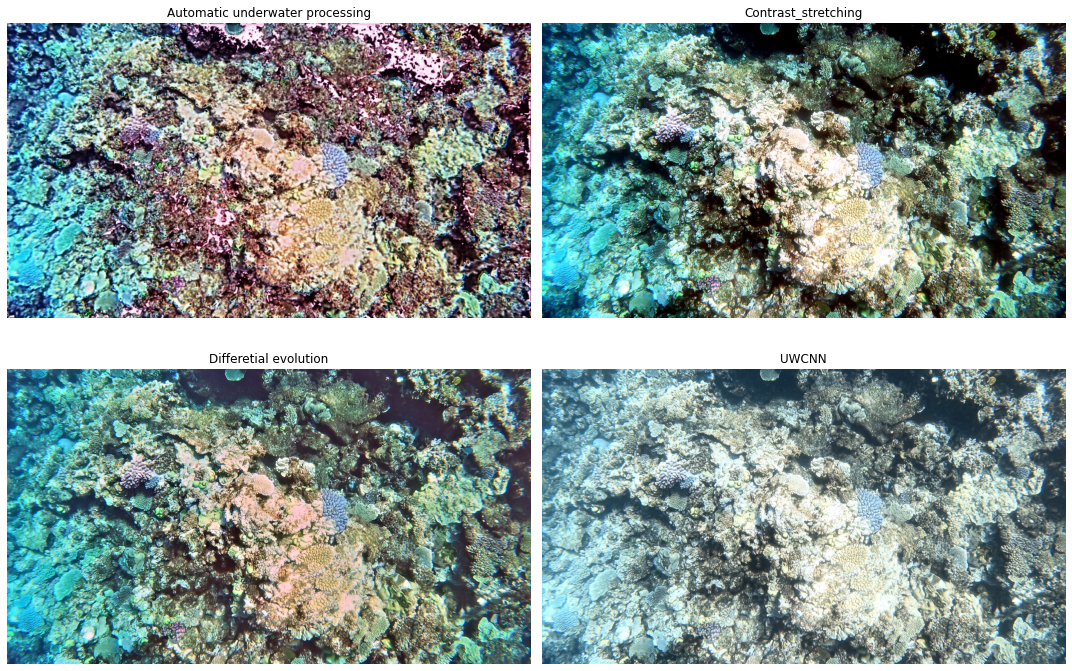

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10),sharex=True, sharey=True)
ax[0][0].imshow(automatic)
ax[0][0].axis('off')
ax[0][0].set_title('Automatic underwater processing')
ax[0][1].imshow(he_hsv)
ax[0][1].axis('off')
ax[0][1].set_title('Contrast_stretching')
ax[1][0].imshow(he_hsv_gf)
ax[1][0].axis('off')
ax[1][0].set_title('Differetial evolution')
ax[1][1].imshow(he_yuv)
ax[1][1].axis('off')
ax[1][1].set_title('UWCNN')
fig.tight_layout()

plt.show()